In [1]:
import sys
import yaml
from os.path import join
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from datasets import TransformedImageDataset, FastMNIST, get_dataset
from evaluate import evaluate
from util import collate_examples_pad, Logger
from models.util import get_model
import models.logpolar
from importlib import reload

import matplotlib.pyplot as plt

In [94]:
experiment_path = "out/Deep_LP_train/mnist/bilinear_trim_new_442478/standard_trim_1"
data_dir = "data"

In [97]:
def scale_ntau(cfig, scale=2):
    for l in cfig['model']['layer_params']:
        if 'tau_max' in l:
            c = (l['tau_max'] / l['tau_min'])**(1. / (l['ntau']-1))-1
            l['c'] = c
            del l['tau_max']
        l['ntau'] = int(l['ntau'] * scale)

In [112]:
## import param file as dict
f = open(join(experiment_path, "train_config.yaml"))
config = yaml.safe_load(f)
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using", config['device'])

scale_ntau(config, 1.5)
## get model and load state dict
model = get_model(config)
# assume model state dict stored as something like MyClassifier.pt
state_dict_path = join(experiment_path, config['model']['classname'] + ".pt")
state_dict = torch.load(open(state_dict_path, "rb"), map_location=config['device'])
model.load_state_dict(state_dict)

Using cpu


<All keys matched successfully>

In [113]:
transform_dict = dict(scale=2)

In [114]:
dataset = get_dataset(config['val_data_dir'], config['device'])

transformed_dataset = TransformedImageDataset(dataset, **transform_dict)
#dataset = FastMNIST(data_dir, device=config['device'], train=False)

In [115]:
def show(x, *args, **kwargs):
    im = x.detach().cpu().numpy()
    if len(x.shape) == 3:
        im = im[0]
    plt.imshow(im, *args, **kwargs)
    plt.show()

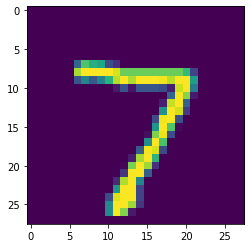

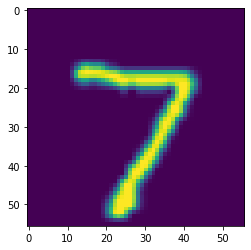

In [116]:
im = dataset[0][0]
im_t = transformed_dataset[0][0]
show(im)
show(im_t)

In [117]:
model

DeepLogPolarClassifier(
  (lpconv_layers): ModuleList(
    (0): LogPolarConv(
      (lpconv): _LogPolar_Core(
        (logpolar): InterpolatedLogPolarTransform(
          ntau=30, tau_range=1:179.70 (c=0.1960), ntheta=12, stride=1
          (filterbank): ShiftedConv2d(
            (pad): ConstantPad2d(padding=(0, 1, 0, 1), value=0)
          )
        )
        (conv): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), bias=False)
        (topk): TopKPool()
        (depth_pool): MaxPool2d(kernel_size=(24, 1), stride=(24, 1), padding=0, dilation=1, ceil_mode=False)
        (spatial_trim): Trim2d(trim_size=(2, 2))
      )
      (act_func): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): LogPolarConv(
      (lpconv): _LogPolar_Core(
        (logpolar): InterpolatedLogPolarTransform(
          ntau=30, tau_range=1:179.70 (c=0.1960), ntheta=12, stride=1
          (filterbank): ShiftedConv2d(
            (pad): ConstantPad2d(padding=(0, 1, 0, 1), value=0)
          )
     

In [118]:
def add_hook(d, name):
    def hook(model, input, output):
        d[name] = output.detach().cpu()
    return hook

def get_activation(model, layer, inp):
    act = None
    def hook(m, i, o):
        nonlocal act
        act = o
    handle = layer.register_forward_hook(hook)
    model(inp)
    handle.remove()
    return act

### Output of first LP-conv layer

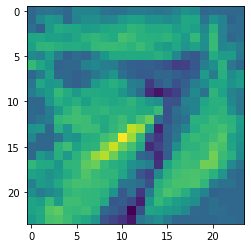

In [119]:
channel = 3
layer = model.lpconv_layers[0].lpconv
out = get_activation(model, layer, im[None])
idx = (0, ..., channel, 0, 0)
show(out[idx])

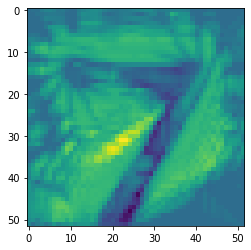

In [120]:
out = get_activation(model, layer, im_t[None])
show(out[idx])

### Output of second LP

torch.Size([1, 32, 30, 12, 24, 24])


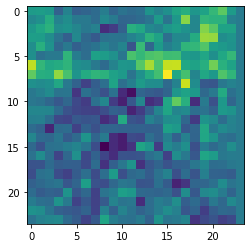

In [121]:
layer = model.lpconv_layers[1].lpconv.logpolar
out = get_activation(model, layer, im[None])
print(out.shape)
idx = (0, channel, 0, 0)
show(out[idx])

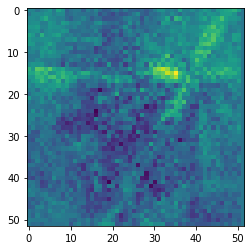

In [122]:
out = get_activation(model, layer, im_t[None])
show(out[idx])

In [123]:
layer.c

0.19603316910412993

### Output of second LPConv `(NOT MATCHING!!)`

torch.Size([1, 20, 20, 32, 1, 12])


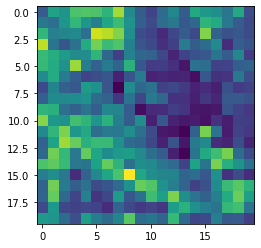

In [124]:
layer = model.lpconv_layers[1].lpconv
out = get_activation(model, layer, im[None])
print(out.shape)
idx = (0, ..., channel, 0, 0)
mx = out[idx].max()
mn = out[idx].min()
show(out[idx], vmax=mx, vmin=mn)

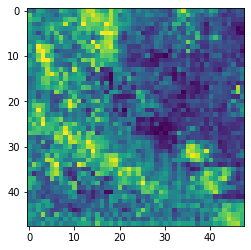

In [125]:
out = get_activation(model, layer, im_t[None])
show(out[idx], vmax=mx, vmin=mn)